In [7]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

import xgboost as xgb

1.0.2


In [3]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

In [4]:
X_all = data[data_cols].T

# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

# Compare XGBoost regression on fed versus fasted data

In [11]:
xgbr = xgb.XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=100, random_state=1)

cv_10 = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)

rbg_scores = cross_val_score(
    xgbr,       
    X_all.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv_10,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    xgbr,       
    X_all.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv_10,            
    n_jobs=7,      
    error_score='raise')

Mean Error:   0.17840073547032195
Median Error: 0.17023421346656165
Standard Dev of errors: 		0.08482909589686671


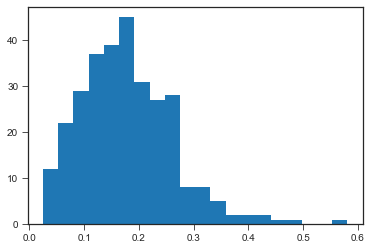

In [12]:
print(f'Mean Error:   {np.mean(-1*rbg_scores)}\n'
      f'Median Error: {np.median(-1*rbg_scores)}\n'
      f'Standard Dev of errors: \t\t{np.std(rbg_scores)}')
plt.hist(-1*rbg_scores, bins=20);

In [23]:
mean_rbg = np.mean(-1 * rbg_scores)
mean_fbg = np.mean(-1 * fbg_scores)
median_rbg = np.median(-1 * rbg_scores)
median_fbg = np.median(-1 * fbg_scores)

errors = pd.DataFrame({'FBG': fbg_scores*-1, 'RBG': rbg_scores*-1}).melt()
errors['dummy'] = 'dummy'
errors.to_csv(r'../data/interim/fasted_vs_fed_model_errors/xgboost.csv')
errors

,variable,value,dummy
0,FBG,0.329504,dummy
1,FBG,0.113178,dummy
2,FBG,0.124246,dummy
3,FBG,0.307417,dummy
4,FBG,0.119056,dummy
...,...,...,...
595,RBG,0.189277,dummy
596,RBG,0.356213,dummy
597,RBG,0.162741,dummy
598,RBG,0.273303,dummy


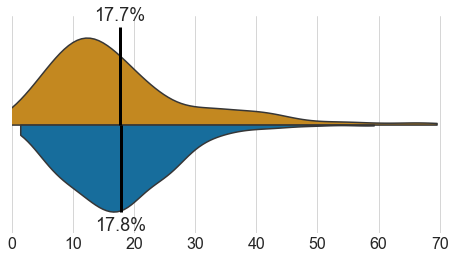

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

vp = sns.violinplot(
    data=errors, x='value', y='dummy',
    orient='h', split=True, hue='variable',
    scale='width', cut=0.4,
    palette=colors, 
    inner=None, 
    ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/xgboost.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/xgboost.svg', bbox_inches='tight', dpi=150)

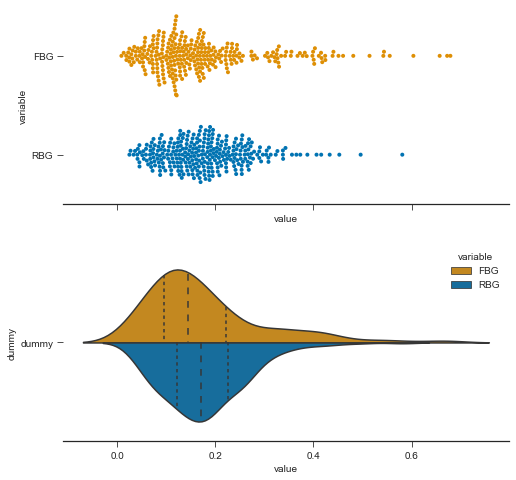

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
sns.swarmplot(
    data=errors, x='value', y='variable',
    s=4, palette=colors, ax=ax1
)
sns.despine(left=True, bottom=True, ax=ax1, fig=fig)

sns.violinplot(
    data=errors, x='value', y='dummy',
    orient='h', split=True, hue='variable',
    palette=colors, inner='quartile', ax=ax2
)
# plt.plot([mean_rbg, mean_rbg], [0, 100])
sns.despine(left=True)

# Grid Search Hyperparameters

In [5]:
def grid_search(X, y, model, params, cv, scoring):
    gs = GridSearchCV(estimator=model,
                      param_grid=params,
                      scoring=scoring,
                      cv=cv,
                      n_jobs=7,)
    result = gs.fit(X, y)
    print("Best: %f using %s" % (result.best_score_, result.best_params_))
    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']
    params = result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    l = []
    for mean, param in zip(means, params):
        d = {'mean': mean, **param}
        l.append(d)
    return pd.DataFrame(l)

In [12]:
xgbr = xgb.XGBRegressor(random_state=1)
params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [10, 20, 40],
    'min_child_weight': [1, 3, 6],
}

# hyperparameter search #1
hp1 = grid_search(X_all, y_ogtt, 
                    xgbr,
                    params=params,
                    cv=10,
                    scoring='neg_mean_absolute_percentage_error'
                    )

Best: -0.127280 using {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.127280 (0.043969) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.128675 (0.044275) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500}
-0.128675 (0.044276) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000}
-0.129619 (0.047946) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100}
-0.130468 (0.047922) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 500}
-0.130468 (0.047921) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 1000}
-0.141665 (0.050936) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 100}
-0.142696 (0.054001) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 

In [15]:
hp1.groupby('learning_rate').mean()

,mean,max_depth,min_child_weight,n_estimators
learning_rate,,,,
0.05,-0.133583,23.333333,3.333333,533.333333
0.10,-0.133490,23.333333,3.333333,533.333333
0.15,-0.134834,23.333333,3.333333,533.333333


In [16]:
hp1.groupby('max_depth').mean()

,mean,learning_rate,min_child_weight,n_estimators
max_depth,,,,
10,-0.133969,0.1,3.333333,533.333333
20,-0.133969,0.1,3.333333,533.333333
40,-0.133969,0.1,3.333333,533.333333


In [17]:
hp1.groupby('min_child_weight').mean()

,mean,learning_rate,max_depth,n_estimators
min_child_weight,,,,
1,-0.131316,0.1,23.333333,533.333333
3,-0.129791,0.1,23.333333,533.333333
6,-0.140800,0.1,23.333333,533.333333


In [18]:
hp1.groupby('n_estimators').mean()

,mean,learning_rate,max_depth,min_child_weight
n_estimators,,,,
100,-0.133713,0.1,23.333333,3.333333
500,-0.134097,0.1,23.333333,3.333333
1000,-0.134097,0.1,23.333333,3.333333


In [20]:
xgbr = xgb.XGBRegressor(random_state=1)
params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [10],
    'min_child_weight': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
}
hp2 = grid_search(X_all, y_ogtt, 
                    xgbr,
                    params=params,
                    cv=10,
                    scoring='neg_mean_absolute_percentage_error'
                    )

Best: -0.127280 using {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0.5, 'n_estimators': 100}
-0.127280 (0.043969) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0.5, 'n_estimators': 100}
-0.127280 (0.043969) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.127573 (0.043033) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1.5, 'n_estimators': 100}
-0.127573 (0.043033) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 100}
-0.129619 (0.047946) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 2.5, 'n_estimators': 100}
-0.129619 (0.047946) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100}
-0.137693 (0.044530) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3.5, 'n_estimators': 100}
-0.137693 (0.044530) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 4, 'n_estim

In [23]:
xgbr = xgb.XGBRegressor(random_state=1)
params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [10],
    'min_child_weight': [1],
    'gamma': [0, 0.1, 0.5, 1, 2, 5, 10]
}
hp3 = grid_search(X_all, y_ogtt, 
                    xgbr,
                    params=params,
                    cv=6,
                    scoring='neg_mean_absolute_percentage_error'
                    )

Best: -0.135795 using {'gamma': 10, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135863 (0.026671) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135877 (0.026649) with: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135883 (0.026657) with: {'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135848 (0.026692) with: {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135855 (0.026643) with: {'gamma': 2, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135839 (0.026591) with: {'gamma': 5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
-0.135795 (0.026714) with: {'gamma': 10, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}


In [27]:
xgbr = xgb.XGBRegressor(n_jobs=7)
params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [10],
    'min_child_weight': [1],
    'gamma': [0],
    'reg_alpha': [0.5],  # L1, generates sparse model
    'reg_lambda': [None]  # L2, quadratic penalty, removes limitation on number of selected variables
}
hp4 = grid_search(X_all, y_ogtt, 
                    xgbr,
                    params=params,
                    cv=10,
                    scoring='neg_mean_absolute_percentage_error'
                    )

Best: -0.128121 using {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': None}
-0.128950 (0.041863) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': None}
-0.128121 (0.038846) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': None}
-0.130541 (0.039335) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': None}
-0.128304 (0.036865) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 2, 'reg_lambda': None}
-0.131577 (0.038414) with: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': None}


In [28]:
xgbfit = xgbr.fit(X_all, y_ogtt)


In [31]:
sum(xgbfit.feature_importances_ > 0)

258

# Hyperparameter search conclusions:
## learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100
## n_jobs=7, random_state=1

## XGBoost gives approximately 13% mean absolute percentage error in 10-fold CV on all 60 samples with all features

## Random Forest gives approximately 18% under the same conditions 